## MLFlow Tracking and Server Setup

In [1]:
import os
import warnings
import sys
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import mean_absolute_error, f1_score , accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import mlflow
import logging
import dagshub


### Set MLflow to use the remote DagsHub tracking server and initialize DagsHub integration for experiment logging

In [2]:
remote_server_uri = "https://dagshub.com/masaba019/mlops.mlflow"
mlflow.set_tracking_uri(remote_server_uri)
dagshub.init(repo_owner='masaba019', repo_name='mlops', mlflow=True)

Accessing as masaba019

Initialized MLflow to track repo "masaba019/mlops"

Repository masaba019/mlops initialized!

# Running the Experiments and Runs
* mlflow.create_experiment(experiment_name) tries to create a new experiment with the given name and returns its ID. If the experiment already exists, it raises an exception, so the code catches it and retrieves the existing experiment's ID with mlflow.get_experiment_by_name(experiment_name).
* mlflow.set_experiment(experiment_name) then sets this experiment as the active one, so all subsequent runs and logs are associated with it. This ensures your tracking is organized under the correct experiment. Would you like a step-by-step breakdown?

In [3]:
# Load data
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


experiment_name = "iris_classification"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
except:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

mlflow.set_experiment(experiment_name)

# Running the Experiments and Runs
with mlflow.start_run(run_name="first_model") as run:
    print("Run ID: ", run.info.run_id)
    print("Expeirment ID: ", run.info.experiment_id)


Run ID:  c430b1f554eb4b99859d15973adf6bb7
Expeirment ID:  1
🏃 View run first_model at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1/runs/c430b1f554eb4b99859d15973adf6bb7
🧪 View experiment at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1


# Adding the Metrics and Parameters

In [11]:
with mlflow.start_run(run_name="random_forest_model") as run:
    print("Run ID: ", run.info.run_id)
    print("Experiment ID:" , run.info.experiment_id)

    n_estimators = 100
    max_depth = 3

    mlflow.log_param("n_estimators" , n_estimators)
    mlflow.log_param("max_depth" , max_depth)

    # Train model
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)
    
    # Evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")


Run ID:  258d139ac9ef4c7d8c01bb24934b66c0
Experiment ID: 1
Accuracy: 0.9666666666666667
F1 Score: 0.9662222222222223
🏃 View run random_forest_model at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1/runs/258d139ac9ef4c7d8c01bb24934b66c0
🧪 View experiment at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1


# Model Artifacts

Run ID:  38ad62efb82742c8bdd2ed8510fc7de0
Experiment ID: 1


2025/10/12 19:45:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model and artifacts logged. Accuracy: 0.9667
🏃 View run model_artifact at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1/runs/38ad62efb82742c8bdd2ed8510fc7de0
🧪 View experiment at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1


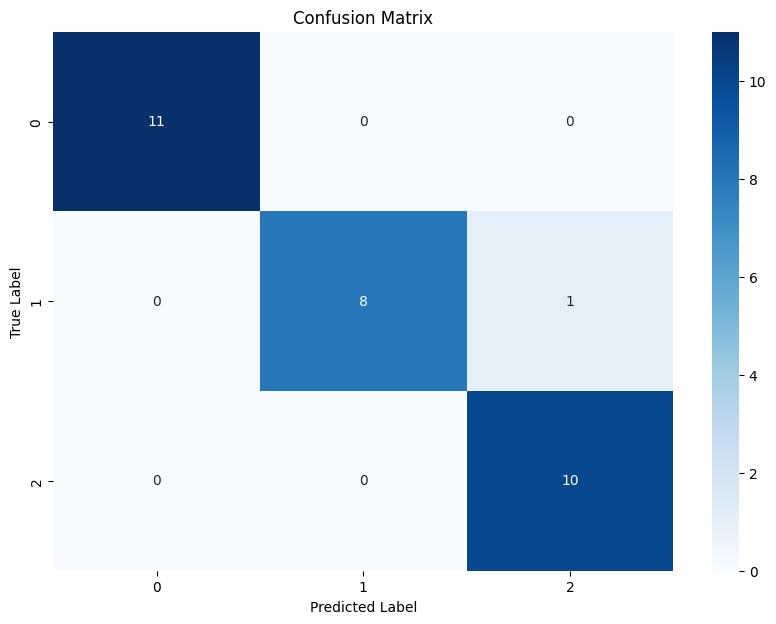

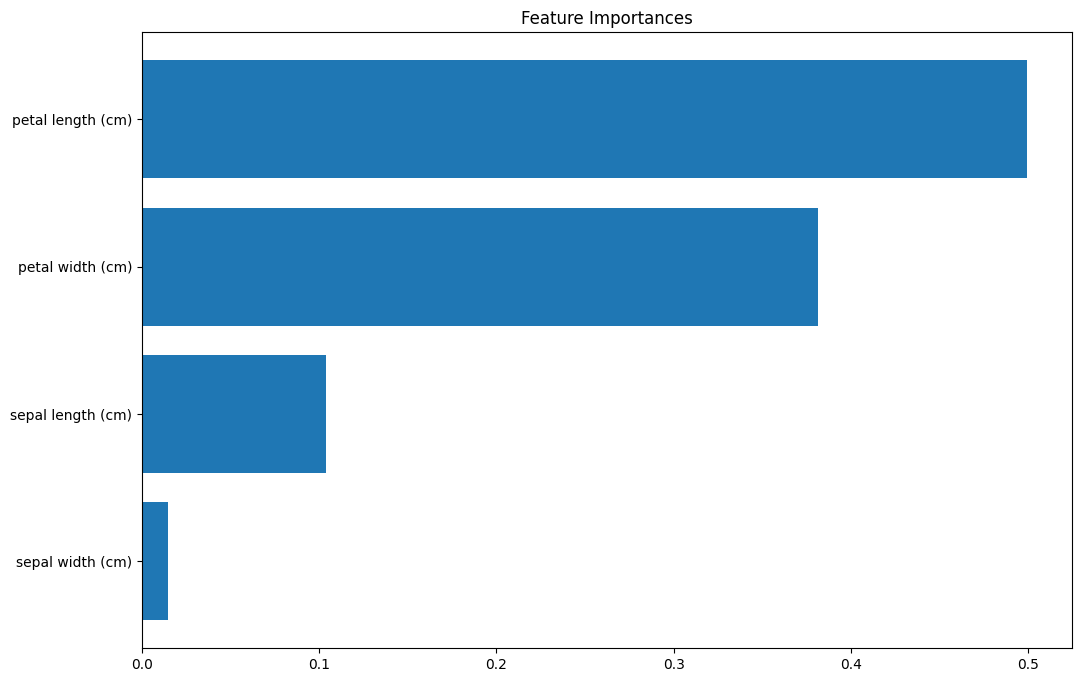

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

with mlflow.start_run(run_name="model_artifact") as run:
    print("Run ID: ", run.info.run_id)
    print("Experiment ID:" , run.info.experiment_id)

    n_estimators = 150
    max_depth = 4

    mlflow.log_params({
        "n_estimators": n_estimators,
        "max_depth": max_depth
    })

    # Train model
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)
    
    # Evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')


    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    # log the model
    mlflow.sklearn.log_model(rf , artifact_path="random_forest_model")

    # create and log confusion matrix plot
    plt.figure(figsize=(10, 7))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png", "plots")

    # Log feature importance plot
    plt.figure(figsize=(12, 8))
    feature_names = load_iris().feature_names
    importances = rf.feature_importances_
    indices = np.argsort(importances)
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title('Feature Importances')
    plt.savefig("feature_importance.png")
    mlflow.log_artifact("feature_importance.png", "plots")

    print(f"Model and artifacts logged. Accuracy: {accuracy:.4f}")



# Tags and Organisation

1. Why do we add tags and what is their use?
* Think of tags as human-readable labels or sticky notes for your MLflow runs. They store static, high-level metadata that helps you organize, search, and filter your experiments.
* In your code, you set mlflow.set_tag("dataset", "Iris"). In the MLflow UI, you can then search for tags.dataset = 'Iris' to see all runs that used this specific dataset.
* You can filter for all runs by a specific author: tags.author = 'masaba019'.
* You can find all classification models: tags.type = 'classification'.

2. What is the use of the signature?
* A model signature is one of the most important features for making your model reliable and easy to deploy. It acts as a formal contract or schema that explicitly defines the model's inputs and outputs.

// The signature defines:

** Inputs: The names of the input columns, their data types (e.g., float, integer, string), and their order.
** Outputs: The name and data type of the model's prediction.

// Key Uses of the Signature:

a) Input Validation and Error Prevention (Most Important!)
This is the primary benefit. When a model is deployed, it will receive data from various sources. The signature ensures that this data is in the correct format before it hits your model's prediction logic.

Without a signature: If you send data with a missing column, a differently named column, or the wrong data type (e.g., sending "5.0" as a string instead of 5.0 as a float), your model will likely crash with a cryptic error.
With a signature: MLflow's serving tools will use the signature to validate the incoming request. It will immediately reject the request with a clear error message like "Input data is missing column 'sepal_width'" or "Invalid type for column 'petal_length', expected double but got string". This makes your deployed model far more robust.

b) Tooling and Deployment Automation
The signature makes the model self-describing. Deployment tools can read the signature to understand how to interact with the model.

API Generation: When you deploy a model with a signature using mlflow models serve, MLflow automatically knows how to structure the REST API endpoint. It knows what the input JSON should look like.
Platform Integration: Other platforms (like Databricks, Seldon Core, or cloud ML services) can inspect the signature to correctly wire up data pipelines to your model without manual configuration.

In [5]:
with mlflow.start_run(run_name="organised_experiment"):
    mlflow.set_tag("model", "RandomForestClassifier")
    mlflow.set_tag("dataset", "Iris")
    mlflow.set_tag("author", "masaba019")
    mlflow.set_tag("version", "1.0")
    mlflow.set_tag("type", "classification")
    mlflow.set_tag("organization", "mlops")

    n_estimators = 200
    max_depth = 5

    mlflow.log_params({
        "n_estimators": n_estimators,
        "max_depth": max_depth
    })

    # Train model
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)
    
    # Evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')


    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    # log model with the signature and input example
    from mlflow.models.signature import infer_signature
    input_example = X_train[:5]

    signature = infer_signature(X_train , rf.predict(X_train))
    mlflow.sklearn.log_model(rf, "model", signature=signature, input_example=input_example)

    print(f"Organized experiment run completed. Accuracy: {accuracy:.4f}")

Organized experiment run completed. Accuracy: 0.9667
🏃 View run organised_experiment at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1/runs/3be9fff8b4ea437ba7019bbc504c058e
🧪 View experiment at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1


## Search and Discovery


In [13]:
from mlflow.tracking import MlflowClient
client = MlflowClient()

experiment = mlflow.get_experiment_by_name("iris_classification")
experiment_id = experiment.experiment_id

print(f"Experiment ID: {experiment_id}")
print(f"Experiment Name: {experiment.name}")

runs = client.search_runs(
    experiment_ids=[experiment_id],
    order_by=["metrics.accuracy DESC"]
)

Experiment ID: 1
Experiment Name: iris_classification


In [15]:
for run in runs:
    print(f"Run ID: {run.info.run_id}")
    print(f"  Accuracy: {run.data.metrics['accuracy']}")
    print(f"  F1 Score: {run.data.metrics['f1_score']}")
    print(f"  Parameters: {run.data.params}")
    print(f"  Tags: {run.data.tags}")
    print("-" * 40)

Run ID: 3be9fff8b4ea437ba7019bbc504c058e
  Accuracy: 0.9666666666666667
  F1 Score: 0.9664799253034547
  Parameters: {'n_estimators': '200', 'max_depth': '5'}
  Tags: {'model': 'RandomForestClassifier', 'mlflow.user': 'masaba019', 'mlflow.source.name': '/workspaces/mlops/.venv/lib/python3.12/site-packages/ipykernel_launcher.py', 'mlflow.source.type': 'LOCAL', 'mlflow.runName': 'organised_experiment', 'version': '1.0', 'mlflow.log-model.history': '[{"run_id": "3be9fff8b4ea437ba7019bbc504c058e", "artifact_path": "model", "utc_time_created": "2025-10-12 19:59:04.941962", "model_uuid": "514ee23560ab4b658abbb52e94fca651", "flavors": {"python_function": {"model_path": "model.pkl", "predict_fn": "predict", "loader_module": "mlflow.sklearn", "python_version": "3.12.1", "env": {"conda": "conda.yaml", "virtualenv": "python_env.yaml"}}, "sklearn": {"pickled_model": "model.pkl", "sklearn_version": "1.7.2", "serialization_format": "cloudpickle", "code": null}}}]', 'organization': 'mlops', 'author':

KeyError: 'accuracy'

# AutoLogging

In [16]:
mlflow.sklearn.autolog()  # Enable autologging for scikit-learn

with mlflow.start_run(run_name="autologged_model") as run:
    print("Run ID: ", run.info.run_id)
    print("Experiment ID:" , run.info.experiment_id)

    n_estimators = 120
    max_depth = 6

    # Train model
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)
    
    # Evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Autologged Model - Accuracy: {accuracy}")
    print(f"Autologged Model - F1 Score: {f1}")

2025/10/12 20:33:16 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


Run ID:  4cb9d5fe517149e0afde2f4d0be46953
Experiment ID: 1
Autologged Model - Accuracy: 0.9666666666666667
Autologged Model - F1 Score: 0.9664799253034547
🏃 View run autologged_model at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1/runs/4cb9d5fe517149e0afde2f4d0be46953
🧪 View experiment at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1


# Parent-Child Runs (Nested Runs)

In [17]:
with mlflow.start_run(run_name="parent_hyperparameter_tuning") as parent_run:
    print("Parent Run ID: ", parent_run.info.run_id)
    print("Experiment ID:" , parent_run.info.experiment_id)

    n_estimators_list = [50, 100]
    max_depth_list = [3, 5]

    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            with mlflow.start_run(run_name=f"child_{n_estimators}_{max_depth}", nested=True) as child_run:
                print(" Child Run ID: ", child_run.info.run_id)

                # Log hyperparameters
                mlflow.log_param("n_estimators", n_estimators)
                mlflow.log_param("max_depth", max_depth)

                # Train model
                rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
                rf.fit(X_train, y_train)
                
                # Evaluate
                y_pred = rf.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average='weighted')

                # Log metrics
                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("f1_score", f1)

                print(f"  Child Model - Accuracy: {accuracy}")
                print(f"  Child Model - F1 Score: {f1}")

Parent Run ID:  216db7cd39b94933b76f0ffe6b14428e
Experiment ID: 1
 Child Run ID:  ff38c5b501de4398a3e1e49d2a53a980
  Child Model - Accuracy: 0.9333333333333333
  Child Model - F1 Score: 0.9333333333333333
🏃 View run child_50_3 at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1/runs/ff38c5b501de4398a3e1e49d2a53a980
🧪 View experiment at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1
 Child Run ID:  b2e09193e8144bc8bcd8944a9c9f2d2b
  Child Model - Accuracy: 0.9666666666666667
  Child Model - F1 Score: 0.9664799253034547
🏃 View run child_50_5 at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1/runs/b2e09193e8144bc8bcd8944a9c9f2d2b
🧪 View experiment at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1
 Child Run ID:  b05588c89faf41dcb14687aaa93ea739
  Child Model - Accuracy: 0.9666666666666667
  Child Model - F1 Score: 0.9664799253034547
🏃 View run child_100_3 at: https://dagshub.com/masaba019/mlops.mlflow/#/experiments/1/runs/b05588c89faf41dcb1